In [169]:
import datetime
import orekit
import logging
import numpy as np
import math
import matplotlib.pyplot as plt

In [170]:
from org.hipparchus.geometry.euclidean.threed import RotationOrder
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.hipparchus.ode.events import Action

In [171]:
from org.orekit.forces.drag import DragForce
from org.orekit.forces.radiation import SolarRadiationPressure
from org.orekit.models.earth.atmosphere import HarrisPriester

In [172]:
from org.orekit.utils import Constants, PVCoordinates, ExtendedPVCoordinatesProvider

In [173]:
from org.orekit.attitudes import AttitudeProvider;
from org.orekit.attitudes import AttitudesSequence;
from org.orekit.attitudes import LofOffset;
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid;
from org.orekit.errors import OrekitException;
from org.orekit.frames import FramesFactory;
from org.orekit.frames import LOFType;
from org.orekit.orbits import KeplerianOrbit, PositionAngle, OrbitType, CircularOrbit
from org.orekit.orbits import Orbit;
from org.orekit.propagation import Propagator;
from org.orekit.propagation import SpacecraftState;
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.propagation.events import EclipseDetector;
from org.orekit.propagation.events import EventDetector;
from org.orekit.propagation.events.handlers import EventHandler, PythonEventHandler;
from org.orekit.propagation.sampling import OrekitFixedStepHandler, PythonOrekitFixedStepHandler
from org.orekit.time import AbsoluteDate;
from org.orekit.time import TimeScalesFactory;
from org.orekit.utils import Constants, IERSConventions, AngularDerivativesFilter
from org.orekit.utils import PVCoordinates;
from org.orekit.utils import PVCoordinatesProvider
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.orekit.propagation.numerical import NumericalPropagator
from org.orekit.propagation import SpacecraftState
from orekit import JArray_double
from org.orekit.forces import BoxAndSolarArraySpacecraft


In [174]:
from org.orekit.attitudes import InertialProvider
from org.orekit.attitudes import NadirPointing
from org.orekit.propagation.sampling import OrekitFixedStepHandler, PythonOrekitFixedStepHandler
from org.orekit.frames import LocalOrbitalFrame, LOFType
from org.hipparchus.geometry.euclidean.threed import RotationOrder, RotationConvention

In [175]:
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate

In [176]:
# set up directory for orekit data
vm = orekit.initVM()
setup_orekit_curdir("../../../orekit-data.zip")

In [177]:
from org.hipparchus.geometry.euclidean.threed import Vector3D

In [178]:
from org.orekit.geometry.fov import CircularFieldOfView, EllipticalFieldOfView

In [179]:
def sso_orbit(**kwargs):
    """Computes keplerian elements of sunsynchronous orbit given the type of sso orbit.
    All units are SI.
    """
    Re = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
    J2 = 1082e-6
    mu = 3.98600442e14 #Constants.WGS84_EARTH_MU
    raandot = 1.991063853e-7
    k = -3*Re**2*J2*np.sqrt(mu)/(2*raandot)

    a = kwargs["a"] if "a" in kwargs else None
    i = kwargs["i"] if "i" in kwargs else None
    e = kwargs["e"] if "e" in kwargs else None
    time = kwargs["time"] if "time" in kwargs else datetime.datetime.utcnow()
    hrs_from_noon = kwargs["hrs_from_noon"] if "hrs_from_noon" in kwargs else 0.0


    if e is not None and i is not None:
        a = np.power(k*np.cos(i)/((1-e**2)**2), 2.0/7.0)
    elif e is not None and a is not None:
        i = np.arccos(np.power(a, 7.0/2.0)*(1-e**2)**2/k)
    elif a is not None and i is not None:
        e = np.sqrt(1 - np.sqrt(k*np.cos(i)/a**(7.0/2.0)))
    else:
        raise ValueError("Insufficient arguments to compute sso. Provide either of (a,i), (a,e), (e,i).")

    ## Compute RAAN given type of SSO
    eme = FramesFactory.getEME2000()
    sun = CelestialBodyFactory.getSun()
    sun_pv = ExtendedPVCoordinatesProvider.cast_(sun)
    sun_coordinates = sun_pv.getPVCoordinates(datetime_to_absolutedate(time), eme)
    sun_position = np.array([sun_coordinates.getPosition().getX(), sun_coordinates.getPosition().getY(), sun_coordinates.getPosition().getZ()])
    theta_sun = np.arctan2(sun_position[1], sun_position[0])
    # theta_sun = np.arccos(sun_position[0]/np.linalg.norm(sun_position))
    print(f"date: {time}, sun position: {sun_position}")
    print(f"sun angle: {np.rad2deg(theta_sun)}")
    raan = theta_sun + hrs_from_noon*2*np.pi/24.0
    if raan < 0:
        raan = 2*np.pi + raan
    return a, e, i, raan

## Define Frames

In [180]:
inertial_frame = FramesFactory.getEME2000()
earth_frame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

In [181]:
earth_shape = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                Constants.WGS84_EARTH_FLATTENING,
                                earth_frame)

In [182]:
sun = CelestialBodyFactory.getSun()

## Define Time

In [183]:
initialDate =  datetime_to_absolutedate(datetime.datetime.utcnow())
duration = float(24*60*60.0)

## Define Initial Orbit

In [184]:

sma = 567.45129e3 + Constants.WGS84_EARTH_EQUATORIAL_RADIUS 
a, e, i, raan = sso_orbit(a=sma, e=0.0, hrs_from_noon=-6.0, time=absolutedate_to_datetime(initialDate))


date: 2021-10-21 13:31:52.474938, sun position: [-1.31384176e+11 -6.43003865e+10 -2.78735891e+10]
sun angle: -153.92253252392433


In [185]:
initial_orbit = CircularOrbit(float(a), float(0.0), float(0.0), float(i),
                              float(raan), float(0.0),
                              PositionAngle.MEAN, inertial_frame,
                              initialDate, Constants.WGS84_EARTH_MU)
position = initial_orbit.getPVCoordinates().getPosition()
velocity = initial_orbit.getPVCoordinates().getVelocity()

## Define Attitude Law

In [186]:

inertialAttitudeLaw = NadirPointing(inertial_frame, earth_shape) # nadir pointing law keeps fixed rotation 

In [187]:
initial_attitude = inertialAttitudeLaw.getAttitude(initial_orbit, initialDate, inertial_frame)

## Define Initial State

In [188]:
initial_sc_state = SpacecraftState(initial_orbit, initial_attitude)

## Define FOV

In [189]:
fov_c = CircularFieldOfView(Vector3D(0.0, 0.0, 1.0), float(np.deg2rad(30)), float(np.deg2rad(-1.0)))

In [210]:
fov_e = EllipticalFieldOfView(Vector3D(0.0, 0.0, 1.0), Vector3D(1.0, 0.0, 0.0), float(np.deg2rad(30)), float(np.deg2rad(30)), float(np.deg2rad(-1.0)))


In [211]:
from org.orekit.frames import Transform

In [212]:
initial_sc_state.getFrame()

<Frame: EME2000>

In [213]:
inert2earth = initial_sc_state.getFrame().getTransformTo(earth_shape.getBodyFrame(), initial_sc_state.getDate())
fov2earth = Transform(initial_sc_state.getDate(), initial_sc_state.toTransform().getInverse(), inert2earth)
footprint = fov_c.getFootprint(fov2earth, earth_shape, float(np.deg2rad(0.01)))

In [214]:
footprint_ell = fov_e.getFootprint(fov2earth, earth_shape, float(np.deg2rad(0.01)))

In [215]:
fov_c.projectToBoundary(fov_c.getCenter())

<Vector3D: {0; 0.5; 0.8660254038}>

In [216]:
date = initial_sc_state.getDate()
pv_inertial = initial_sc_state.getPVCoordinates()
t = initial_sc_state.getFrame().getTransformTo(earth_shape.getBodyFrame(), date)
p = t.transformPosition(pv_inertial.getPosition())
v = t.transformVector(pv_inertial.getVelocity())
center = earth_shape.transform(p, earth_shape.getBodyFrame(), date)
center

<GeodeticPoint: {lat: -0.0520405019 deg, lon: -116.8305410328 deg, alt: 567,451.3075038558}>

In [217]:
import ast

In [218]:
str_geodetic = str(footprint.get(0)).replace(' deg', '')
str_geodetic = str_geodetic.replace('lat', "\'lat\'")
str_geodetic = str_geodetic.replace('lon', "\'lon\'")
str_geodetic = str_geodetic.replace('alt', "\'alt\'")
print(f"str geodetic")

str geodetic


In [219]:
str_geodetic_ell = str(footprint_ell.get(0)).replace(' deg', '')
str_geodetic_ell = str_geodetic_ell.replace('lat', "\'lat\'")
str_geodetic_ell = str_geodetic_ell.replace('lon', "\'lon\'")
str_geodetic_ell = str_geodetic_ell.replace('alt', "\'alt\'")
print(f"str geodetic")

str geodetic


In [220]:
footprint_list = ast.literal_eval(str_geodetic)

In [221]:
footprint_list_ell = ast.literal_eval(str_geodetic_ell)

In [222]:
fp_lat = [g.get("lat") for g in footprint_list]
fp_lon = [g.get("lon") for g in footprint_list]

In [223]:
fp_lat_ell = [g.get("lat") for g in footprint_list_ell]
fp_lon_ell = [g.get("lon") for g in footprint_list_ell]

In [224]:
import cartopy.crs as ccrs

In [225]:
center.getLongitude()

-2.0390776079087587

In [226]:
from cartopy.feature.nightshade import Nightshade

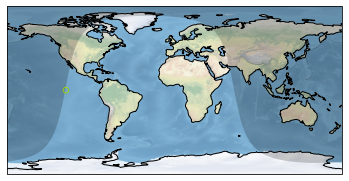

In [227]:
fig_gt = plt.figure("Ground Track SSO")
ax_gt = plt.axes(projection=ccrs.PlateCarree())
ax_gt.coastlines()
ax_gt.stock_img()
ax_gt.add_feature(Nightshade(absolutedate_to_datetime(initial_sc_state.getDate()), alpha=0.2))
# ax_gt.plot(np.rad2deg(center.getLongitude()), np.rad2deg(center.getLatitude()), transform=ccrs.Geodetic(), marker=".", color="red")
ax_gt.plot(fp_lon, fp_lat, transform=ccrs.Geodetic(), alpha=0.6, color='green', zorder=3, linewidth=1)
ax_gt.plot(fp_lon_ell, fp_lat_ell, transform=ccrs.Geodetic(), alpha=0.6, color='yellow', zorder=3, linewidth=1)

